In [37]:
import json
import pprint as pp
with open('protein_annotation.json') as json_file:
    data = json.load(json_file)
pp.pprint(data)

{'ABC': {'Domains': {'DBD': [[278, 346]], 'IDR': [[1, 277]]}, 'Length': 358},
 'DEFG': {'Domains': {'DBD': [[352, 402]], 'IDR': [[403, 591]]},
          'Length': 516,
          'Motifs': {'PLD': [[432, 516]]}},
 'PQRST': {'Domains': {'DBD': [[100, 186]], 'LBD': [[174, 432]]},
           'Length': 432}}


darkseagreen was assigned to LBD
Final domain color assignment: {'IDR': 'green', 'DBD': 'purple', 'LBD': 'darkseagreen'}
Protein PQRST does not have Motifs, moving to next protein.
Protein ABC does not have Motifs, moving to next protein.
Final motif color assignment: {'P': 'fuchsia', 'PLD': 'red', 'D': 'antiquewhite'}

 Motif not plotted for PQRST. Motif not provided.

 Motif not plotted for ABC. Motif not provided.


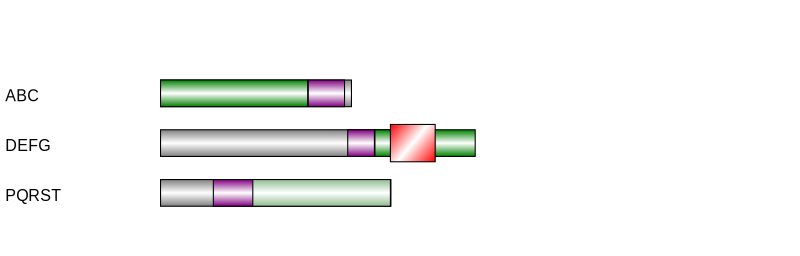

In [38]:
prot_annot = data


## Reorder plot. In the absence of provided order, this block will simply flip the dictionary
# -------------------------------------------------------------------------------
desired_plot_order_list = sorted(list(prot_annot.keys())) # Alphabetically sorted.

# ['ASCL1', 'PQR', 'DEF', 'MNO']

def reorder_dictionary(order_list, input_dictionary):
    order_list.reverse()
    #desired_order_list
    desired_order_dict = {x: input_dictionary[x] for x in order_list}
    return desired_order_dict # This dictionary in reality is a miror image of the desired dictionary

if 'desired_order_list' not in globals():
    desired_order_list = list(prot_annot.keys())

prot_annot = reorder_dictionary(desired_plot_order_list, prot_annot)
# -------------------------------------------------------------------------------


domain_color = dict()
domain_color = {'IDR': 'green', 'DBD': 'purple'}
motif_color = dict()
motif_color = {'P': 'fuchsia', 'PLD': 'red', 'D': 'antiquewhite'}
# Place to visit for color choice guidance: https://color.adobe.com


# -------------------------------------------------------------------------------
# Function to select a subset of colors from all available colors in mpl 
def get_n_mpl_colors(n):
    import matplotlib as mpl
    import random
    mpl_color_list = list(mpl.colors.cnames.keys())
    color_list = random.sample(mpl_color_list, n)
    return color_list
# -------------------------------------------------------------------------------



def get_all_attribute_entries(attribute_name, protein_dictionary):
    """Get all entries for specific attribute. For example, get all domain names for all proteins the whole dataset."""
    all_attribute_list = []
    for i in protein_dictionary:
        try:
            all_attribute_list.extend(list(protein_dictionary[i][attribute_name]))
        except:
            print(f'Protein {i} does not have {attribute_name}, moving to next protein.')
    all_attribute_list = list(set(all_attribute_list))
    return all_attribute_list
# Comment: Seems like dictionary keys should be enough for this! Perhaps this function is not necessary, after I 
# converted input to json/dictionary format.

# -------------------------------------------------------------------------------
# If all domains are not properly assigned colors.
# Randomly assigning colors to domains that were not assigned colors.

domain_list = get_all_attribute_entries('Domains', prot_annot)

for i in domain_list:
    if i not in domain_color.keys():
        domain_color[i] = get_n_mpl_colors(1)[0]
        print(f'{domain_color[i]} was assigned to {i}')
print('Final domain color assignment:', domain_color)

# -------------------------------------------------------------------------------

# -------------------------------------------------------------------------------
# If all motifs are not properly assigned colors.
# Randomly assigning colors to motifs that were not assigned colors.

motif_list = get_all_attribute_entries('Motifs', prot_annot)

for i in motif_list:
    if i not in motif_color.keys():
        motif_color[i] = get_n_mpl_colors(1)[0]
        print(f'{motif_color[i]} was assigned to {i}')
print('Final motif color assignment:', motif_color)

# -------------------------------------------------------------------------------


## Plot parameters
# -------------------------------------------------------------------------------
base_height = .5
extended_height = .7
inter_protein_space = extended_height/3
centering_offset = (extended_height-base_height)/2
box_height = {'protein': base_height, 'domain': base_height, 'motif': extended_height}

# -------------------------------------------------------------------------------

# SVG plot 
# -------------------------------------------------------------------------------
import drawSvg as draw
# Source : https://github.com/cduck/drawSvg
# Refs: https://developer.mozilla.org/en-US/docs/Web/SVG/Tutorial/Gradients
#       https://thebookofshaders.com/05/

d1 = draw.Drawing(15, (extended_height + inter_protein_space)*len(prot_annot)+2, origin=(0,0))
# Drawing(width, height, origin=(0, 0), idPrefix='d', displayInline=True, **svgArgs)
# Feature req: Drawing width should be based on length of the longest protein, this should be dynamically fetched from input.


def draw_rectangle_linear_gradient(x1, y1, width, height, colour, gradient_select='horizontal'):
    try:
        del gradient
    except:
        pass
    
    # Defining gradients; start. ----------------------------------------------
    left_slant_gradient = draw.LinearGradient(x1,y1,x1+width,y1+height)                 # Semi-diagonal, left slant. 
                                                                              # In between vertical and diagonal gradient
    right_slant_gradient = draw.LinearGradient(x1+width,y1,x1,y1+height)                 # Semi-diagonal, right slant. 
                                                                              # In between vertical and diagonal gradient
    horizontal_gradient = draw.LinearGradient((x1+width)/2,y1,(x1+width)/2,y1+height)   # Horizontal gradient
    vertical_gradient = draw.LinearGradient(x1,(y1+height)/2,x1+width,(y1+height)/2)  # Vertical gradient
    
    gradient_dict = {'horizontal': horizontal_gradient, 
                    'vertical': vertical_gradient, 
                    'left-slant': left_slant_gradient,
                    'right-slant': right_slant_gradient
                  }
    # Defining gradients; end. ----------------------------------------------
    
    gradient = gradient_dict[gradient_select]
    gradient.addStop(0, colour, 1)   
    gradient.addStop(0.5, 'white', 1)
    gradient.addStop(1, colour, 1)
    #gradient2.addStop(.25, 'black', 1)=
    
    d1.append(draw.Rectangle(x1,y1,width,height,
                            stroke='black', stroke_width=0.02,
                            fill=gradient,
                            fill_opacity=1,))


def write_text(txt_to_write, x_pos, y_pos, txt_size = 0.3, fill_colour = 'black', my_title='protein_title'):
        # Ref: Details on SVG text - https://developer.mozilla.org/en-US/docs/Web/SVG/Element/text
        # Comment: Dash ('-') in the attribute name should be replaced with underscore ('_'), 
        #          at least for font_style (not font-style)!
        # Font family: https://developer.mozilla.org/en-US/docs/Web/CSS/font-family

        d1.append(draw.Text(txt_to_write, 
                        txt_size, 
                        x_pos, y_pos, 
                        fill=fill_colour, 
                        font_style='Regular', 
                        font_family='Arial',
                        title=my_title))

loop_count =1
spacing_coeff = 1                      # To control the spacing between consecutive entries.
protein_box_left_alignment_pos = 3     # Left alignment positions for all protein schemes, you may need to change this
                                       # if names of your proteins are too big!



for protein_entry in prot_annot:
    # Writing protein name
    write_text(protein_entry, 
               0.1, loop_count*(extended_height + inter_protein_space)+ centering_offset) # Better logic needed
                                                                                         # This is a short-cut solution
    
    # Drawing protein (complete)
    try:
        protein_box_length = prot_annot[protein_entry]['Length']/100
        draw_rectangle_linear_gradient(protein_box_left_alignment_pos + 1/100,
                                       loop_count*(extended_height + inter_protein_space)  ,
                                       protein_box_length,
                                       box_height['protein'], 
                                       'grey')
    except:
        print(f'\nProtein not plotted for {protein_entry}.Whole protein length not provided. Proceeding to domain draw.')
    # Drawing protein domains:
    try:
        for domain in prot_annot[protein_entry]['Domains']:
            for domain_coordinate in prot_annot[protein_entry]['Domains'][domain]:
                domain_start_pos = domain_coordinate[0]
                domain_end_pos =  domain_coordinate[1]
                domain_box_length = (domain_end_pos - domain_start_pos)/100
                draw_rectangle_linear_gradient(protein_box_left_alignment_pos + domain_start_pos/100,
                                           loop_count*(extended_height + inter_protein_space),
                                           domain_box_length,
                                           box_height['domain'], # Need to check this one- why domain is in quote?
                                           domain_color[domain])
    except:
        print(f'\n Domain not plotted for {protein_entry}. Domain not provided. Proceeding to motif draw.')
    # Drawing protein motifs:
    try:
        for motif in prot_annot[protein_entry]['Motifs']:
            for motif_coordinate in prot_annot[protein_entry]['Motifs'][motif]:
                motif_start_pos = motif_coordinate[0]
                motif_end_pos =  motif_coordinate[1]
                motif_box_length = (motif_end_pos - motif_start_pos)/100
                draw_rectangle_linear_gradient(protein_box_left_alignment_pos + motif_start_pos/100,
                                               loop_count*(extended_height + inter_protein_space) - centering_offset,
                                               motif_box_length,
                                               box_height['motif'], 
                                               motif_color[motif],
                                                'right-slant')
    except:
        print(f'\n Motif not plotted for {protein_entry}. Motif not provided.')
        
        
    loop_count +=1    


# Display
d1.setRenderSize(w=800)
#d1.saveSvg('gb_svg.svg')

In [33]:
import cairosvg
cairosvg.svg2pdf(url='gb_svg.svg', write_to='gb_svg.pdf')